## Vilzuallizing the b-scan from the original 99_R_2_1_Segm.xls file

- imageID is the B-scan number in F column and 1st row and then 36, 70 and so on
- for each b-scan layers are stored in order starting from 3rd row with increment of 3 rows. Then the layers for the next b-scan start from 37th row and then 71 and so on



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# For reading .xls files, install xlrd otherwise comment out the import
import xlrd

In [6]:
file_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/test_annotations.xlsx'

In [7]:
#load the xlsx file
data = pd.read_excel(file_path, engine='openpyxl')
#for the orioginal .xls file format
#data = xlrd.open_workbook('/home/suraj/Git/SCR-Progression/99_R_2_1_Segm.xls')

In [13]:
#define the layers
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']

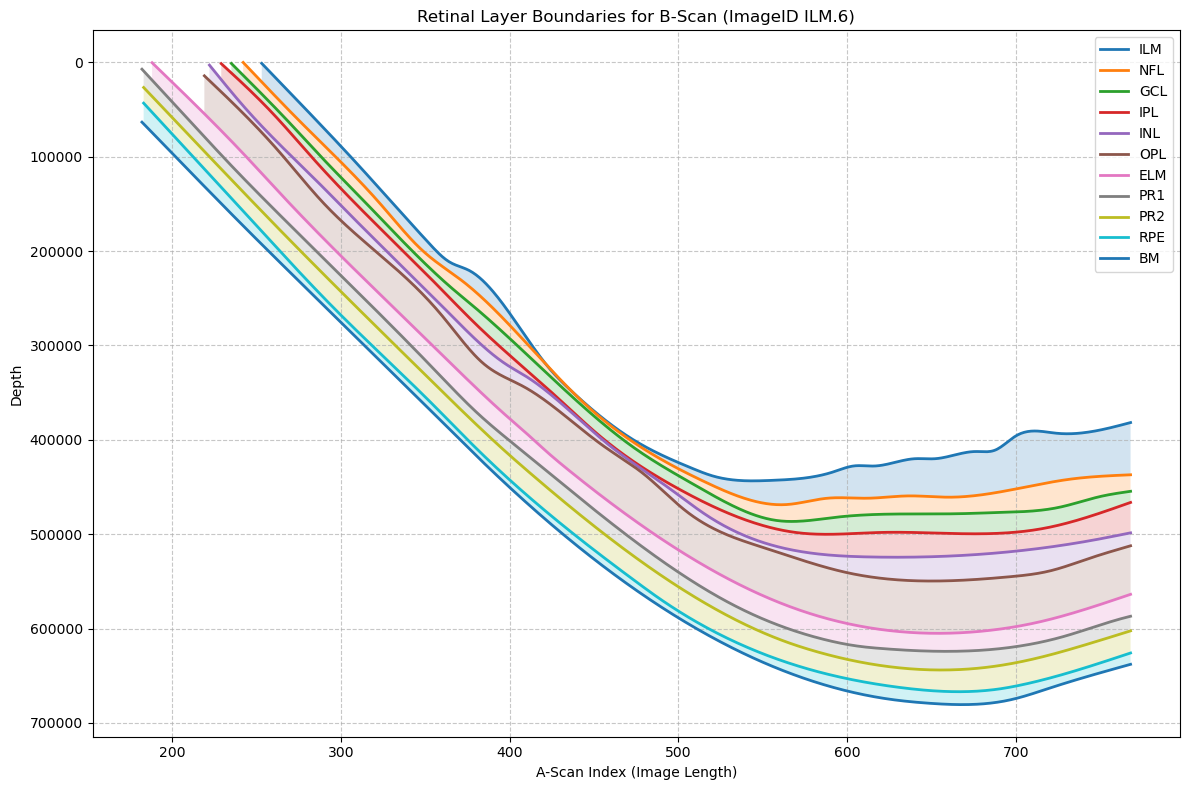

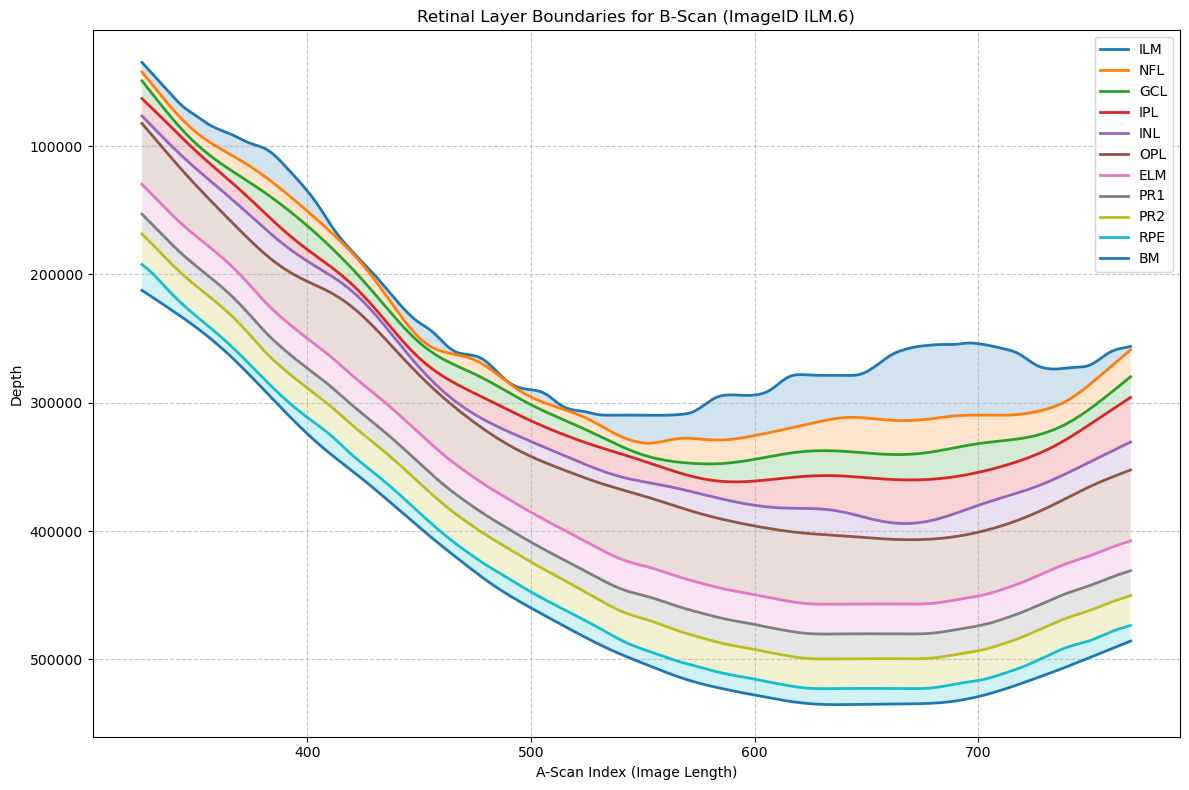

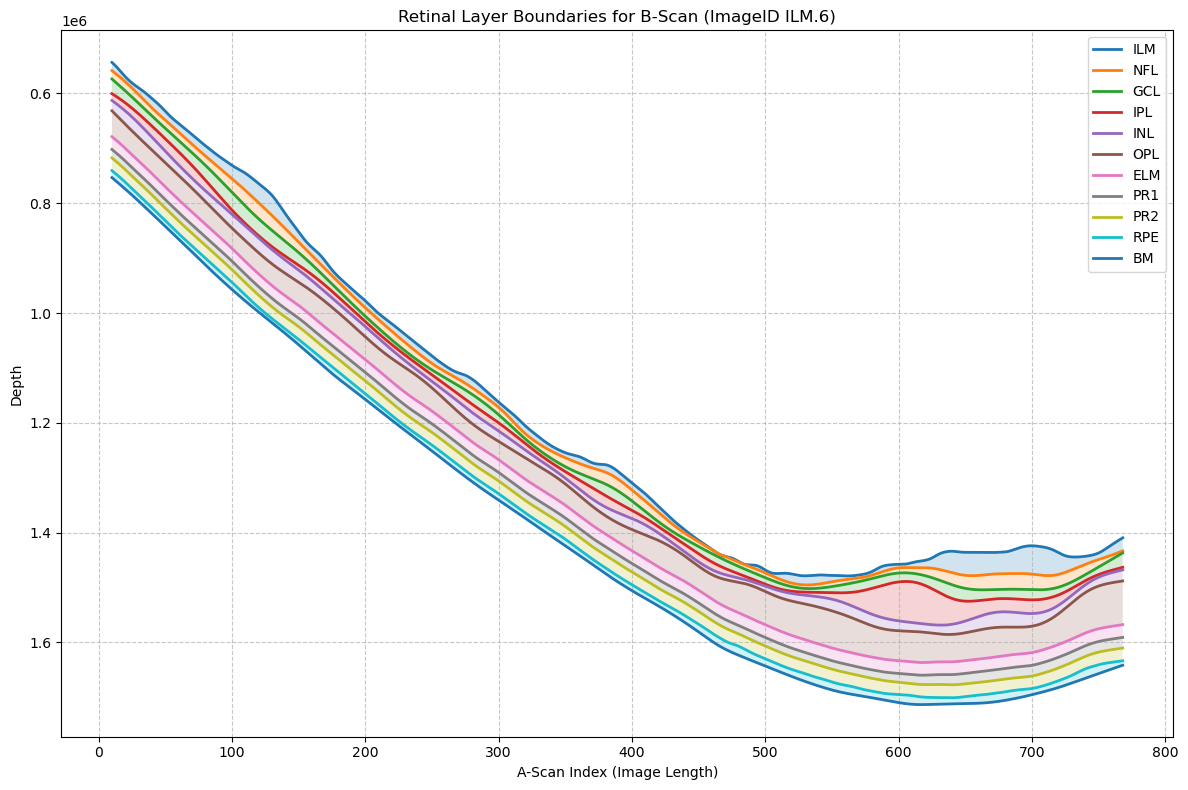

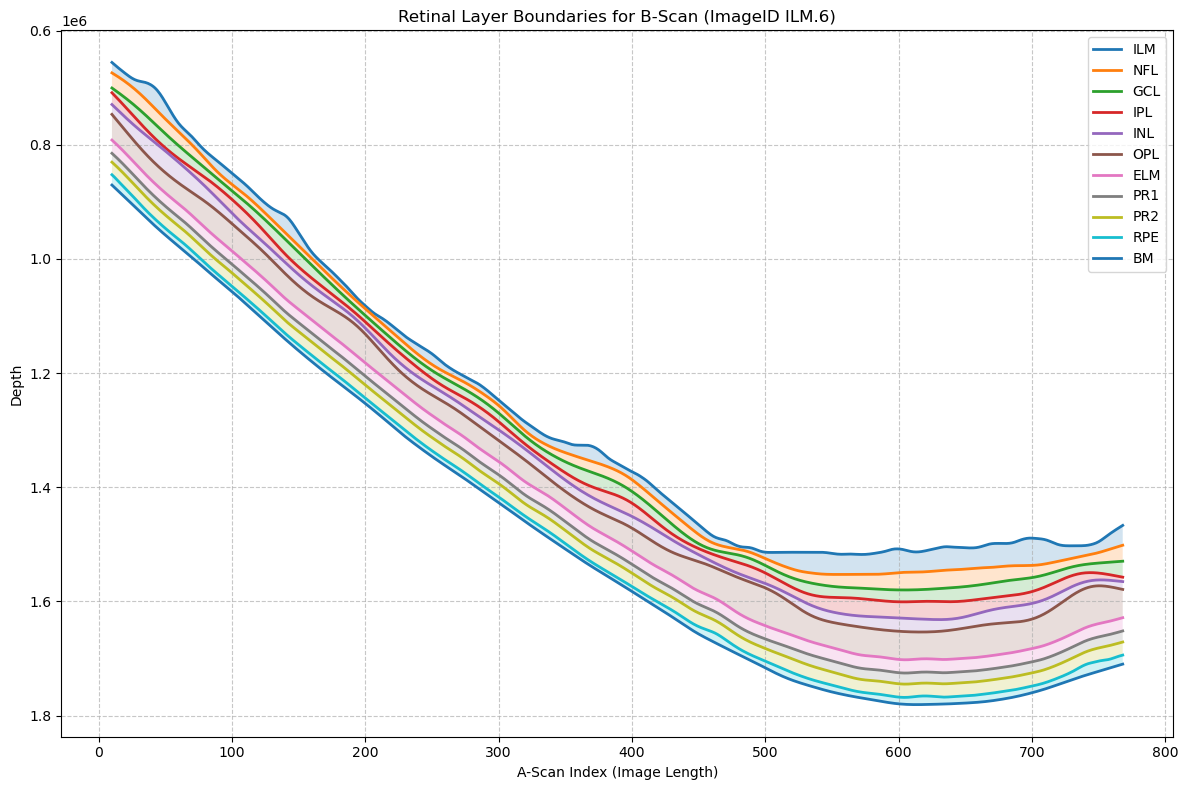

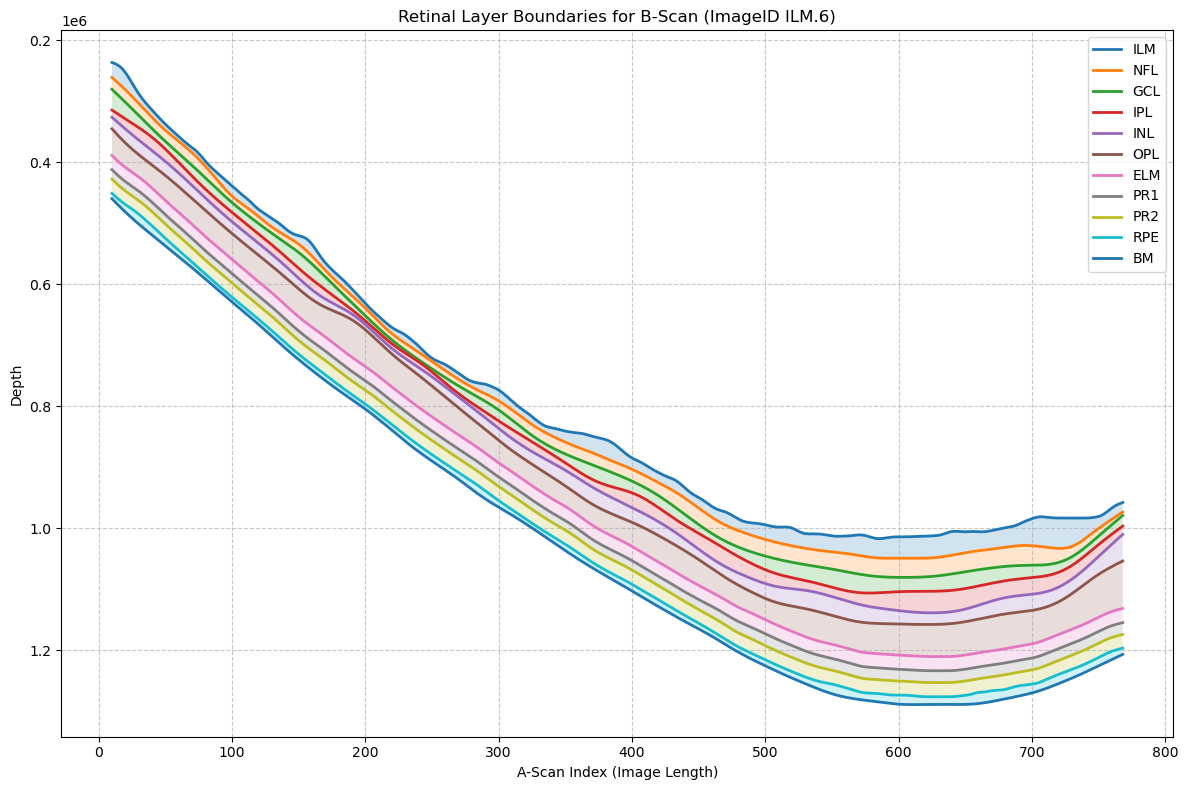

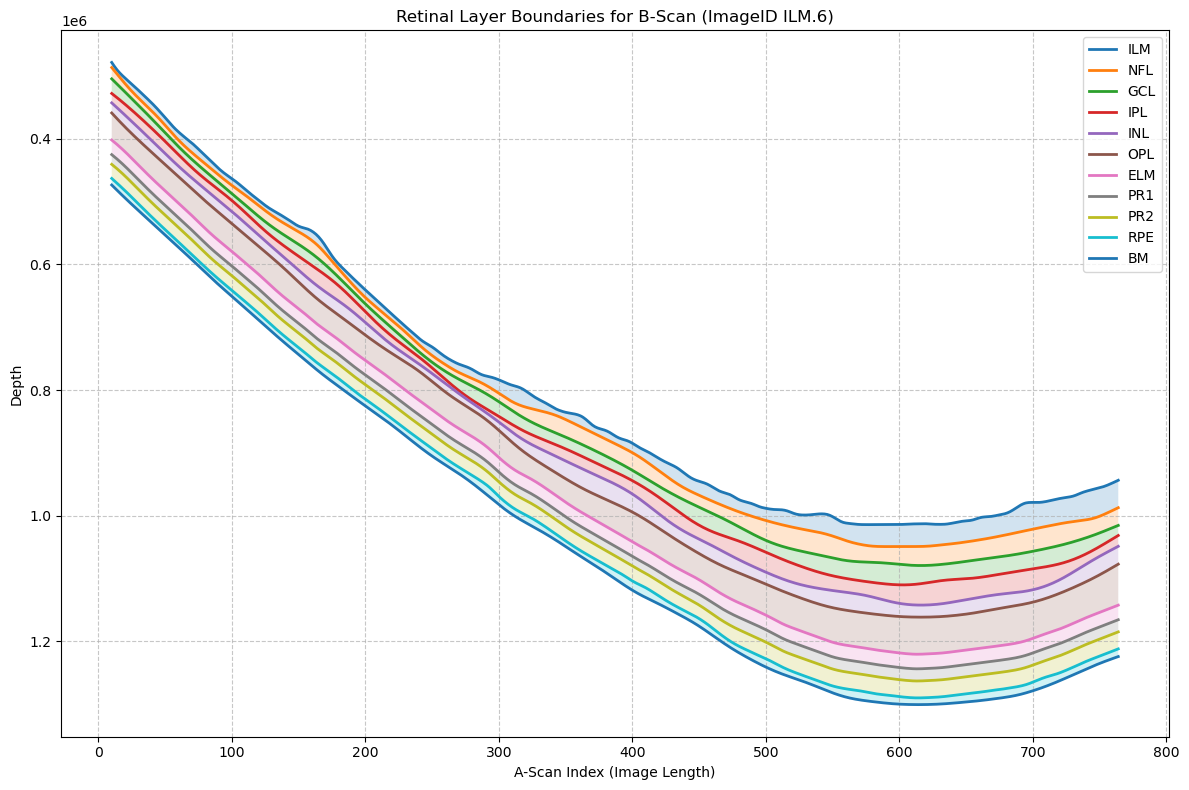

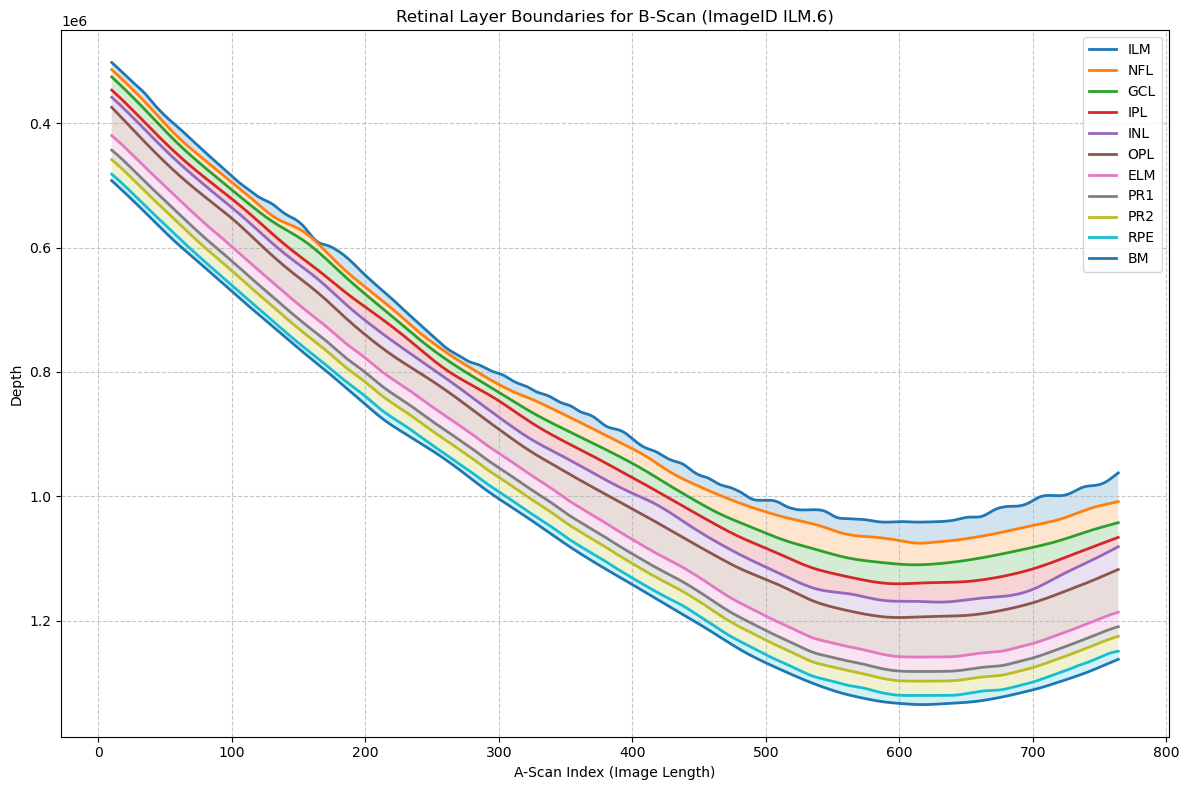

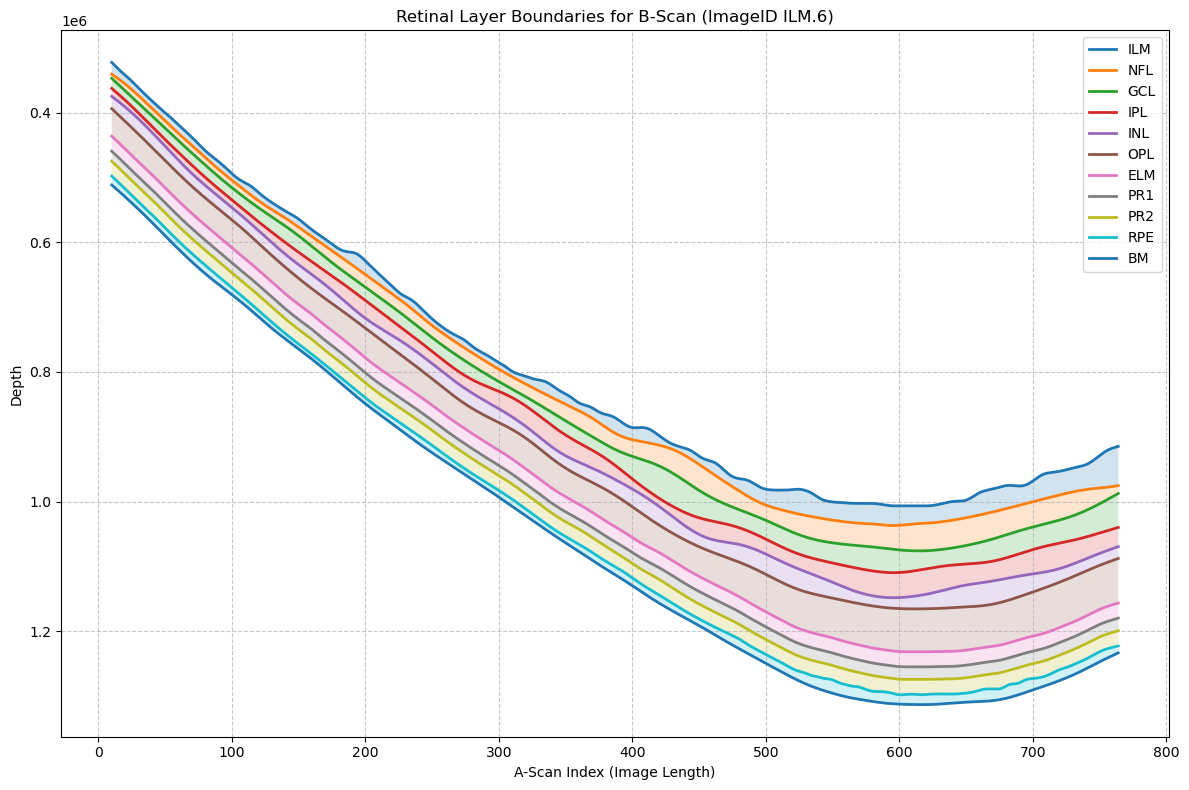

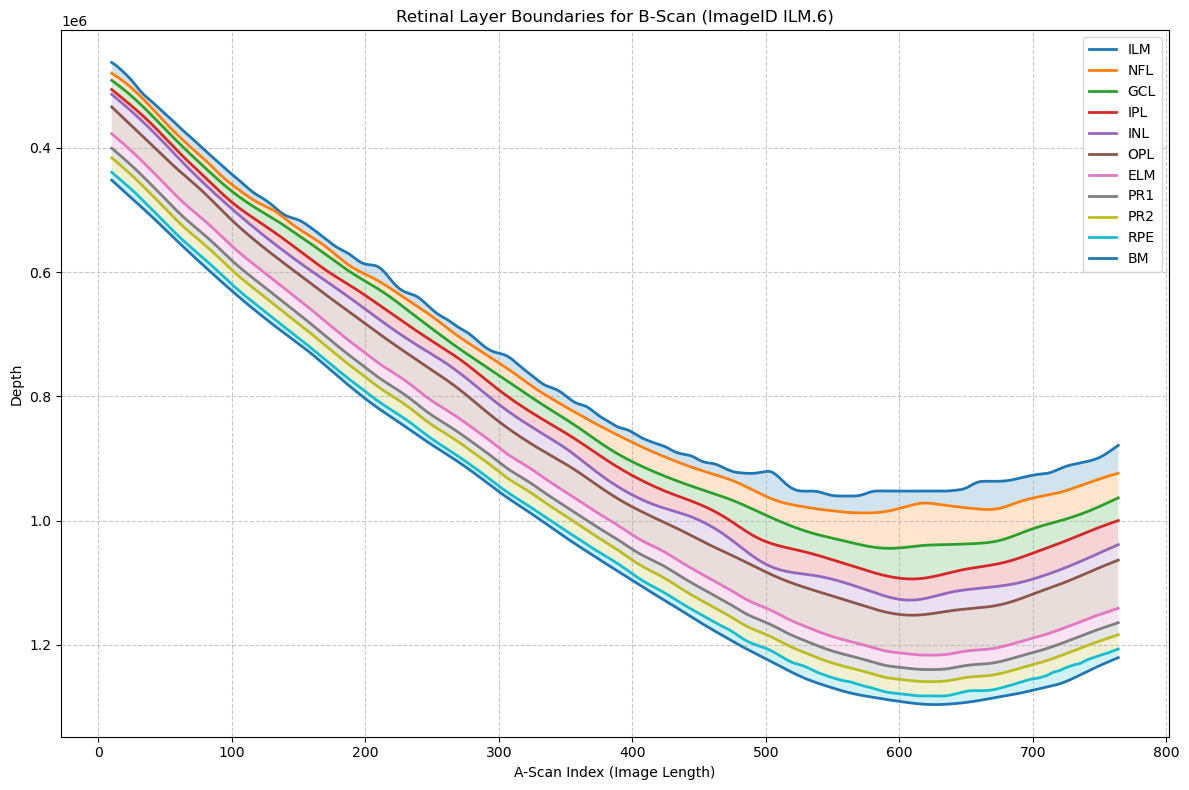

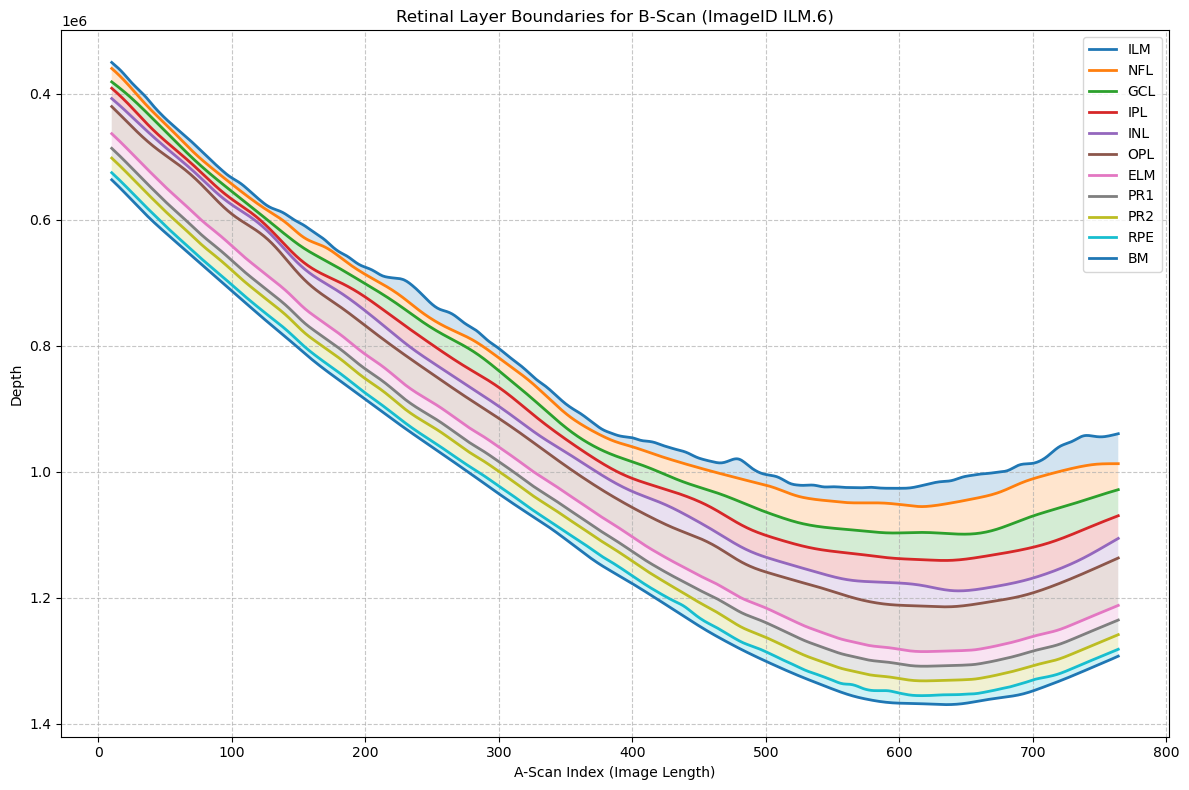

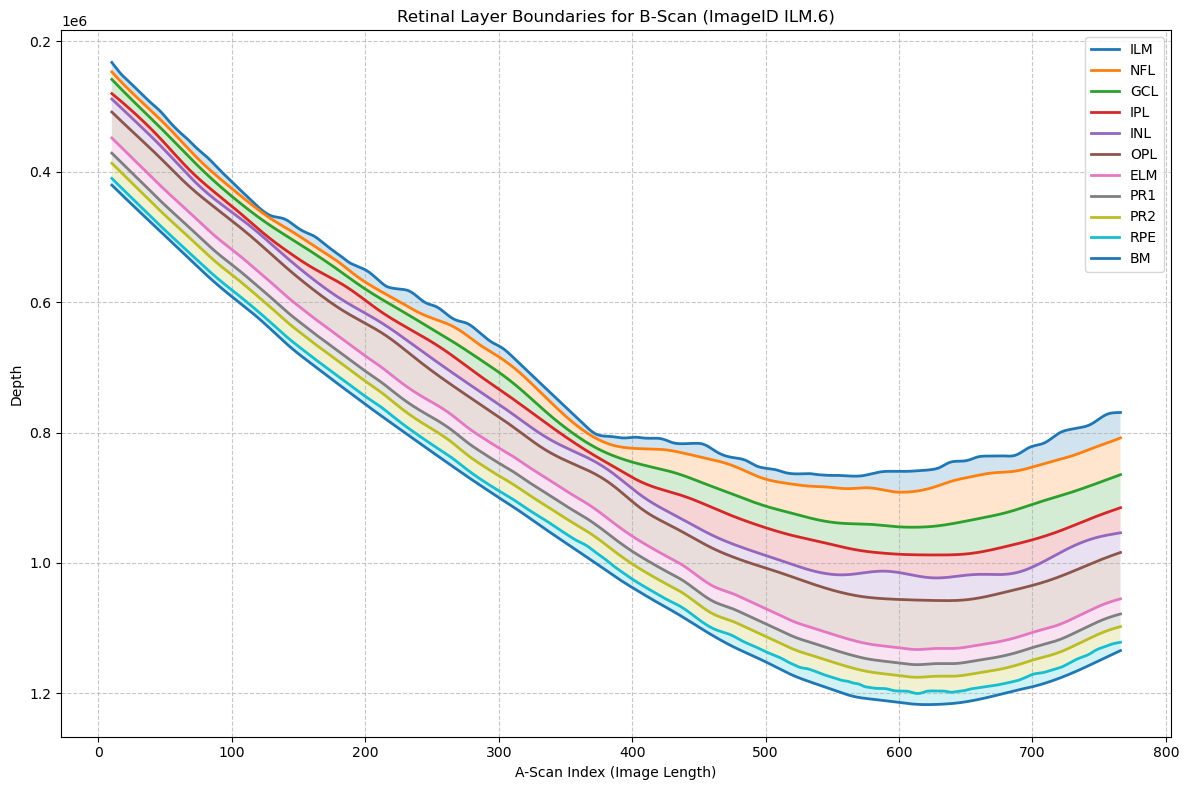

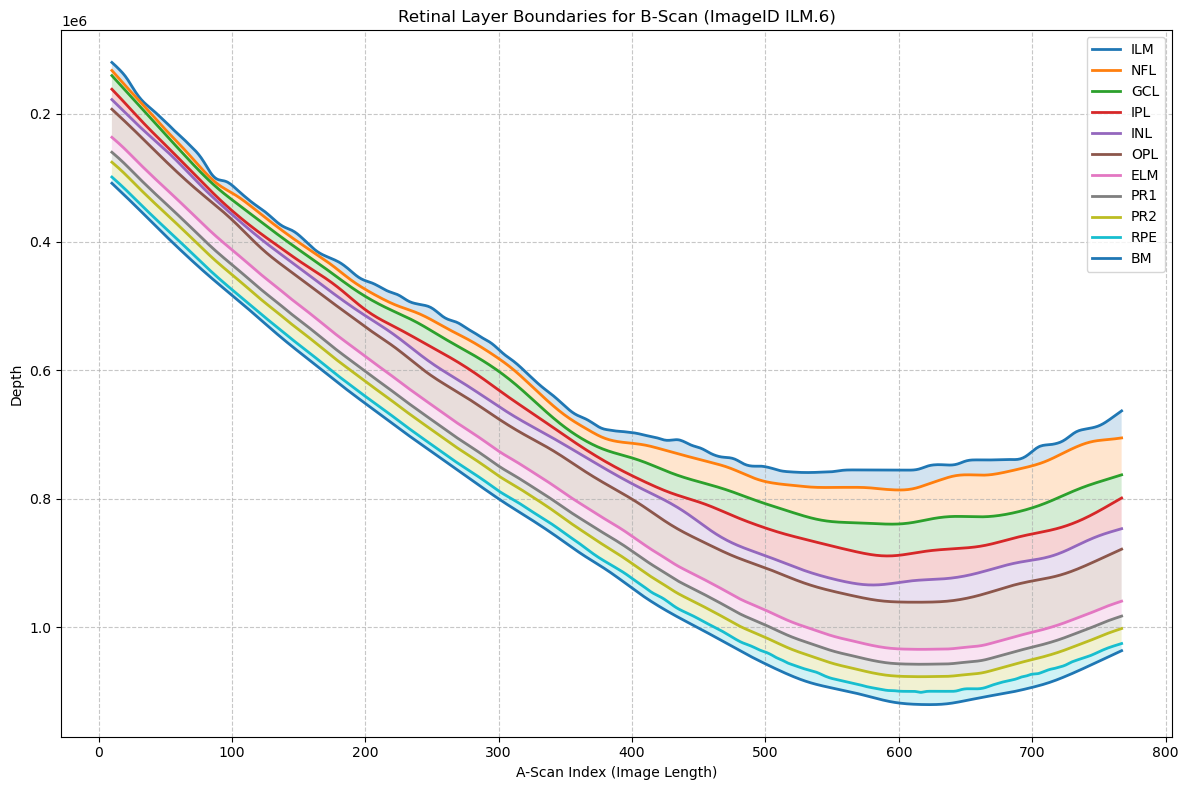

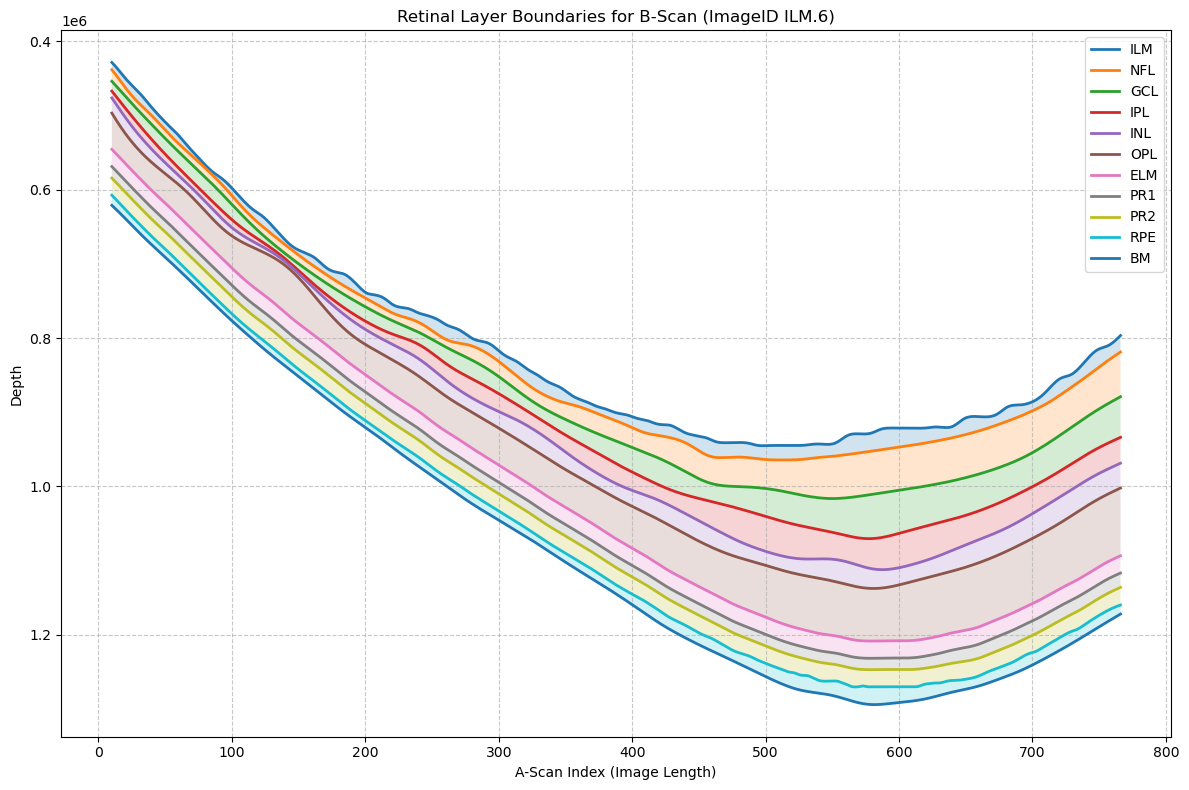

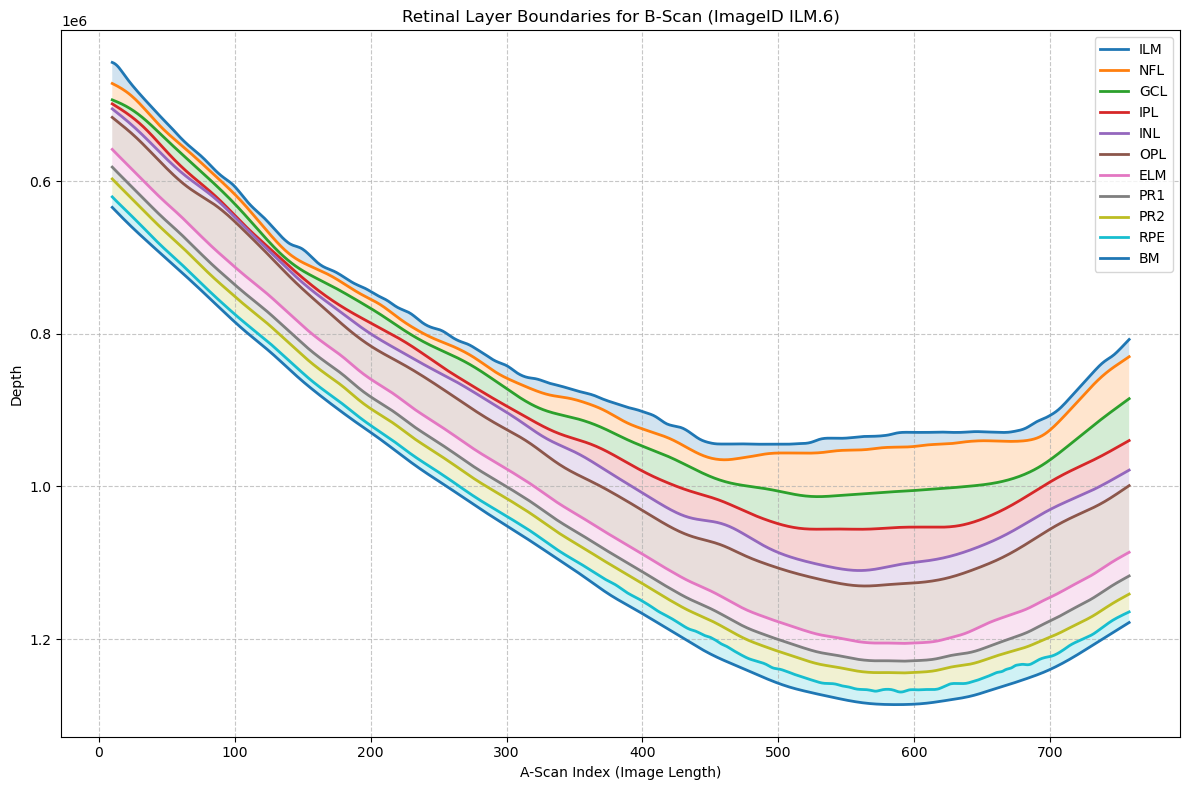

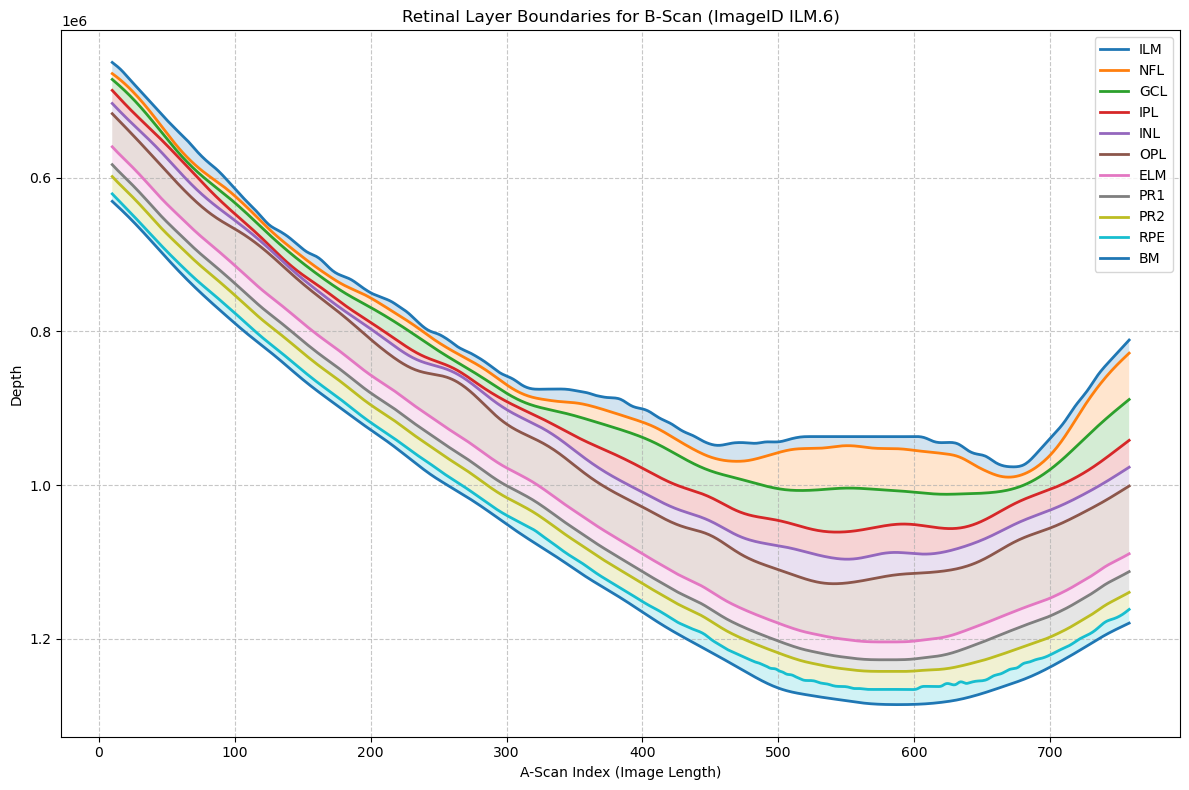

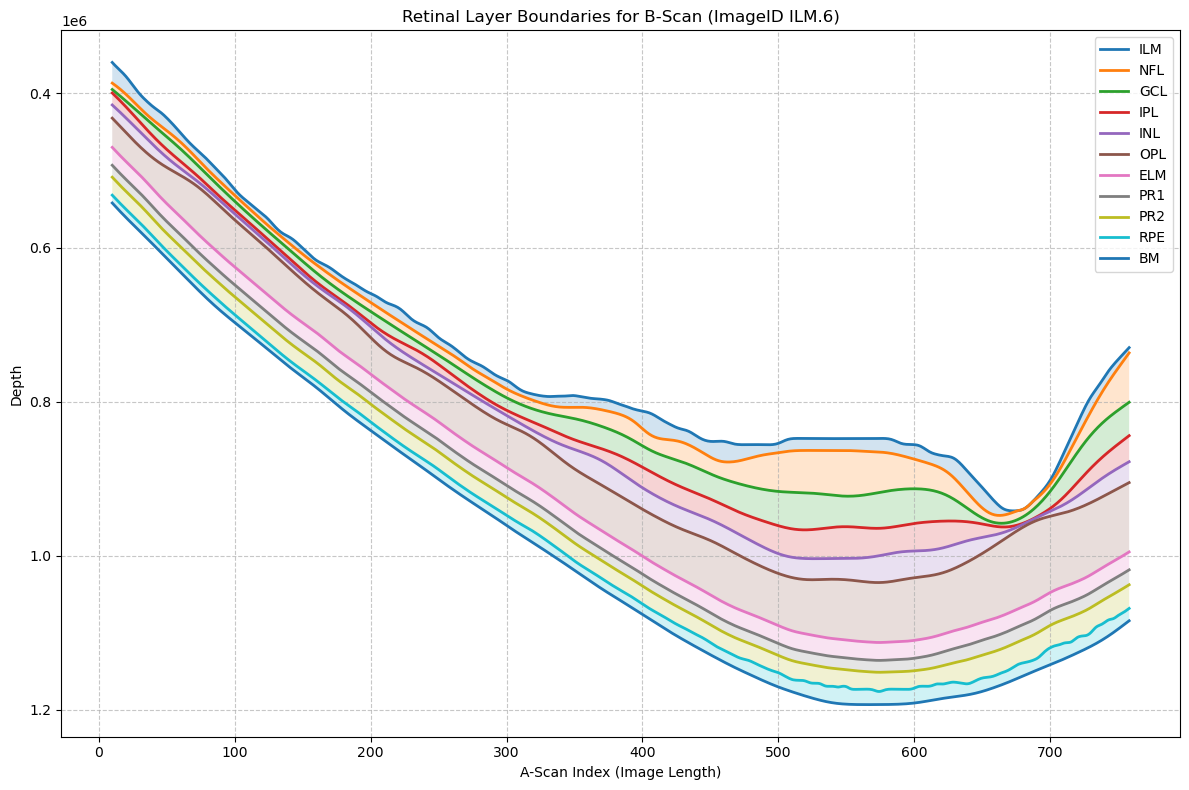

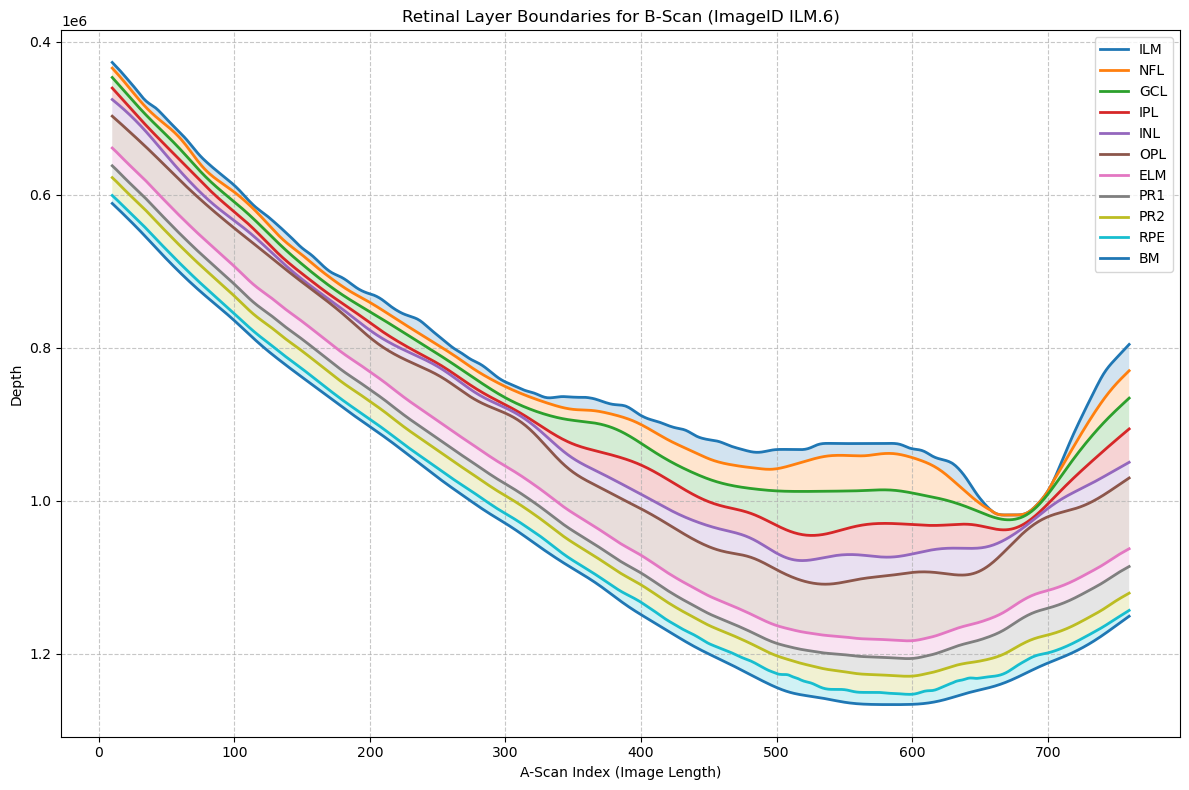

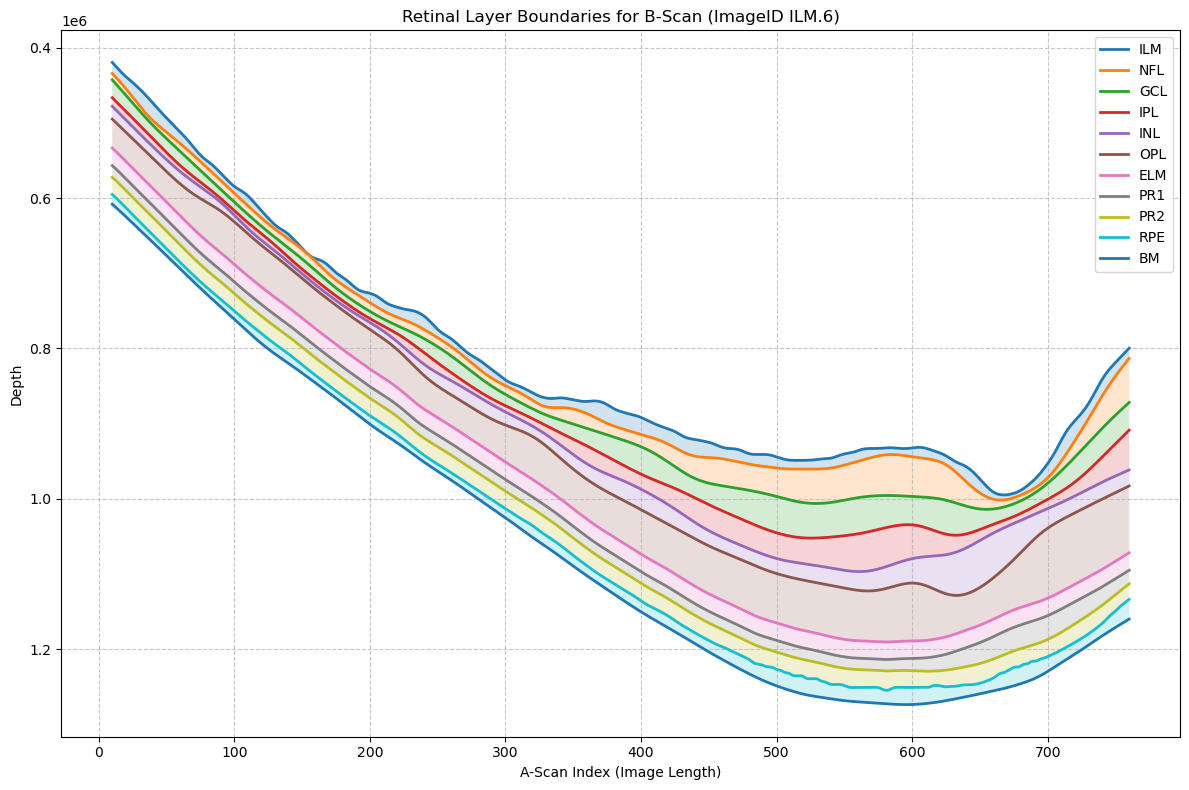

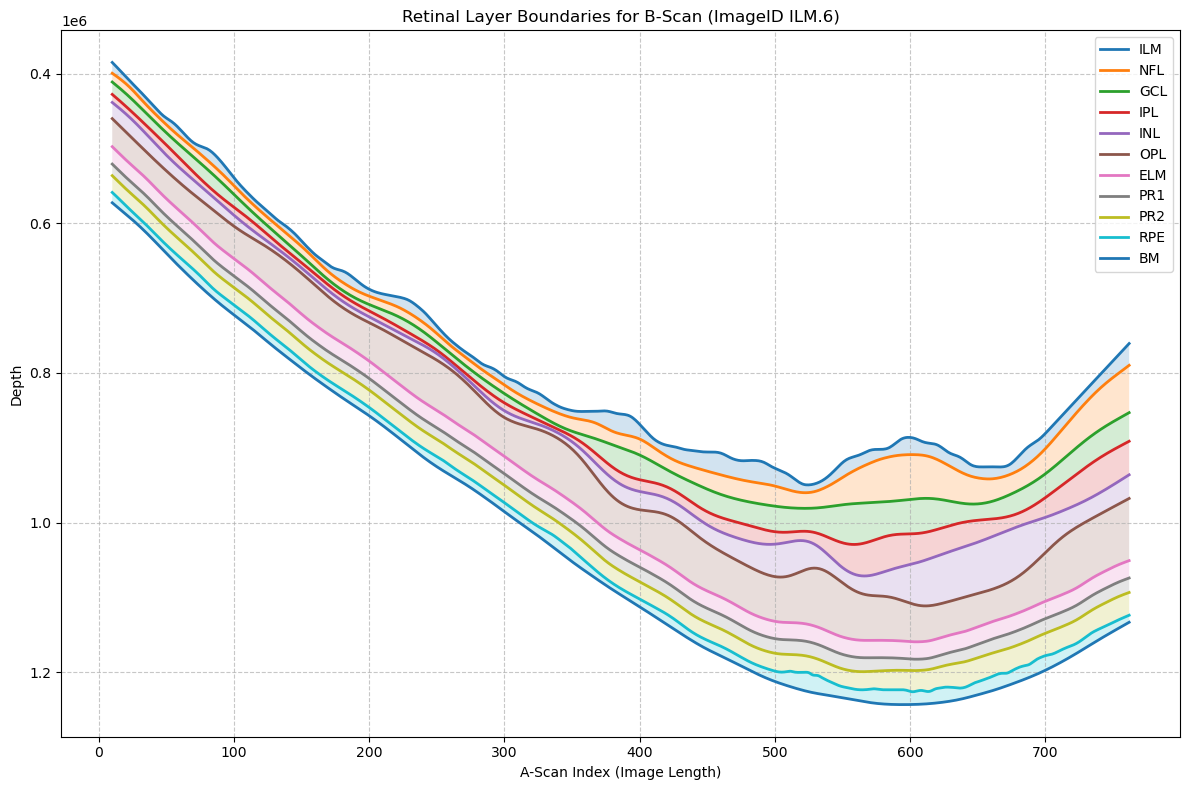

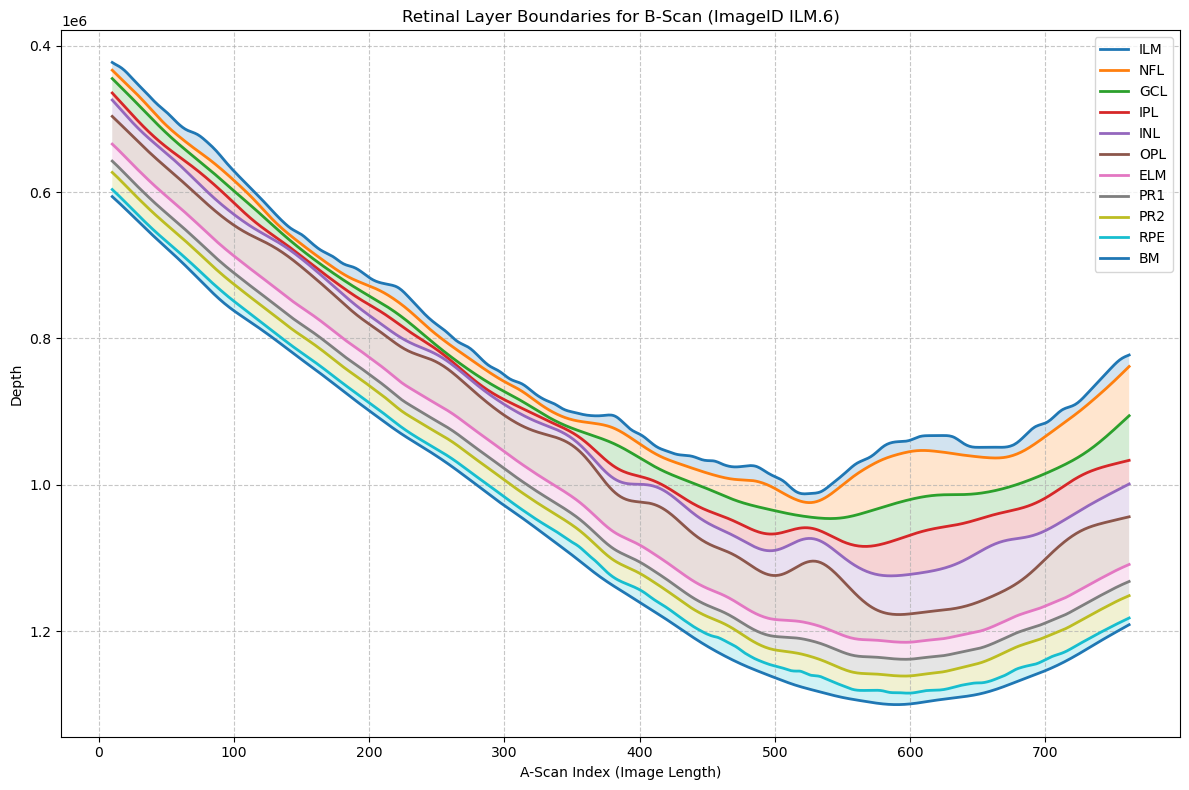

KeyboardInterrupt: 

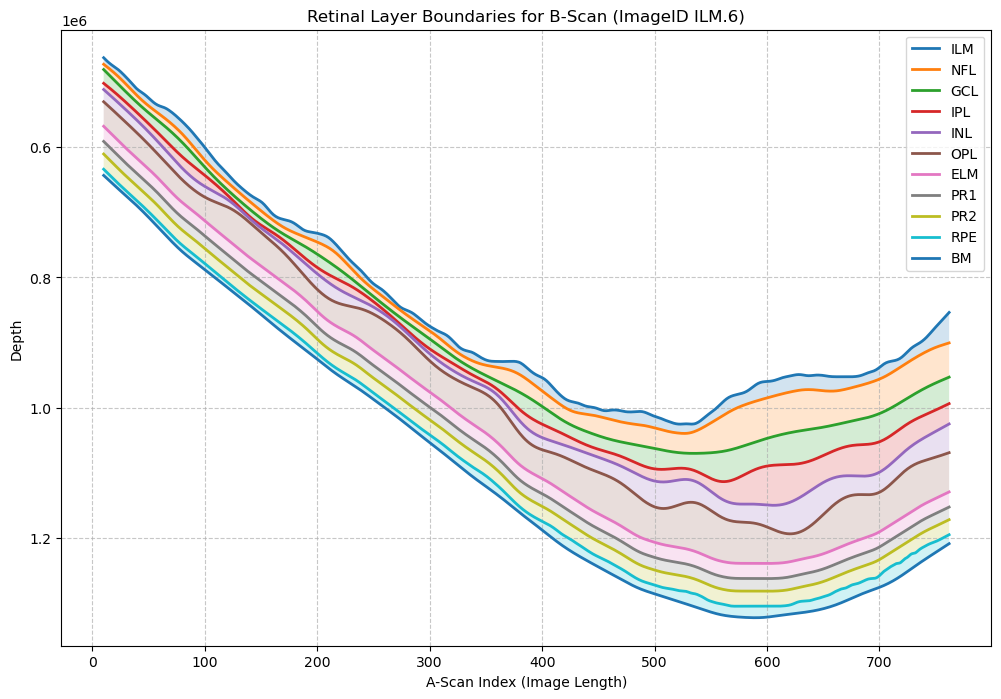

In [23]:
#loop through all the B-scans
row_idx = 1 #starting row for first ImageID
while row_idx < len(data):
    #get the ImageID for the current B-scan
    image_id = data.iloc[row_idx, 5]  # ImageID is in column F (0 based index: 5)
    
    if pd.isna(image_id) or image_id is None: #breaks the loop if no more ImageID present
        break 
    
    # Determine the layer rows for the current B-scan
    start_row = row_idx + 2  # Layers start 2 row after ImageID

    layer_rows = [start_row + i * 3 for i in range(len(layers))]  # 11  layers, each 3 rows apart

    # Initialize the plot
    plt.figure(figsize=(12, 8))
    previous_y = None

    # Plot each layer
    for layer, row_idx_layer in zip(layers, layer_rows):
        # Extract the row for the current layer
        layer_data = data.iloc[row_idx_layer - 1, :] # Adjust for 0-based indexing
        # Get valid data (columns 260 to 768, 0-based index 259 to 767)
        x = range(10, 769) # A-scan indices
        y = layer_data[9:768].values # Depth values
        # Convert to numeric, handling any non-numeric values
        y = pd.to_numeric(y, errors='coerce')

        # Plot the layer
        plt.plot(x, y, label=layer, linewidth=2)

        # Fill between this layer and the previous one
        if previous_y is not None:
            plt.fill_between(x, previous_y, y, alpha=0.2)
        previous_y = y

    # Customize the plot
    plt.xlabel('A-Scan Index (Image Length)')
    plt.ylabel('Depth')
    plt.title(f'Retinal Layer Boundaries for B-Scan (ImageID {image_id})')
    plt.legend()
    plt.gca().invert_yaxis() # Invert y-axis so deeper layers appear lower
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'bscan_{image_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # move to the next B-scan
    row_idx += 34

In [ ]:
def plot_bscan_layers(data, layers, layer_rows)-> None:
    """
    Plots the retinal layer boundaries for a B-scan from OCT data.
    
    Args:
    - data: DataFrame containing the OCT data.
    - layers: List of layer names to plot.
    - layer_rows: List of row indices corresponding to each layer in the DataFrame.
    """

## Plotting a single b-scan using hardcoded data

In [18]:
file_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/test_annotations.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

In [16]:
# Define the layers (update with actual layer names if different)
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
layer_rows = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32]

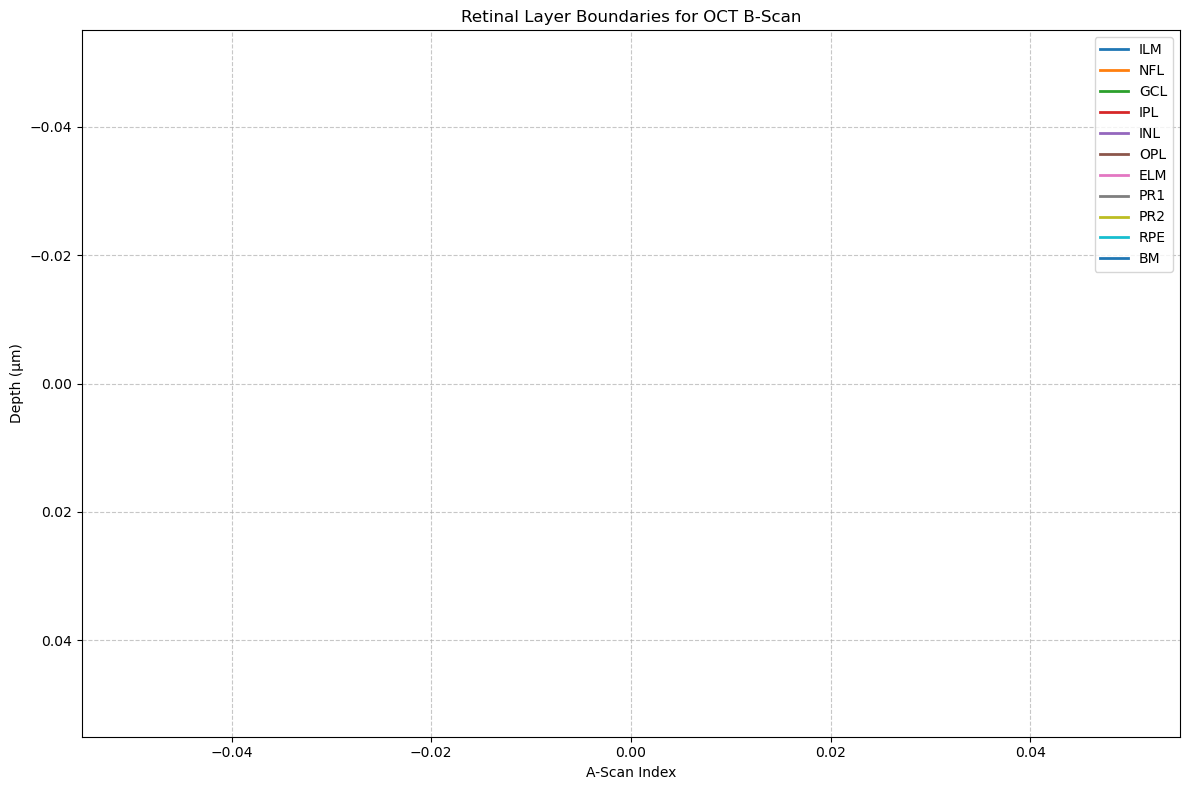

In [19]:
#plotting the First B-scan layers

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot each layer and fill between consecutive layers
previous_y = None
for i, (layer, row_idx) in enumerate(zip(layers, layer_rows)):
    # Extract the row for the current layer
    layer_data = data.iloc[row_idx - 1, :] # Adjust for 0-based indexing
    # Get valid data (columns 260 to 768, 0-based index 259 to 767)
    x = range(10, 769) # A-scan indices
    y = layer_data[9:768].values # Depth values (columns 260 to 768)
    # Convert to numeric, handling any non-numeric values
    y = pd.to_numeric(y, errors='coerce')
    # Plot the layer
    plt.plot(x, y, label=layer, linewidth=2)
    # Fill between this layer and the previous one
    if previous_y is not None:
        plt.fill_between(x, previous_y, y, alpha=0.2)
    previous_y = y

# Customize the plot
plt.xlabel('A-Scan Index')
plt.ylabel('Depth (µm)')
plt.title('Retinal Layer Boundaries for OCT B-Scan')
plt.legend()
plt.gca().invert_yaxis() # Invert y-axis so deeper layers appear lower
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [30]:
max_y = np.nanmax(y)
print("Max value of y-axis for sample annotation:", max_y)

Max value of y-axis for sample annotation: 1217243.0


## Annotations storing and normalizing
- Extract annotations from the excel files per bscan
- Normalize the annotations
- store them in a .h5 dataset
- amend the dataset with new b-scan annotation and image pairs

In [11]:
import numpy as np
import pandas as pd
import h5py

def extract_all_layer_maps(data, layers, bscan_start_rows, layer_rows_offset=2, layer_row_step=3, num_x=768):
    """
    Extracts all B-scan layer annotations and saves them to an .h5 file.
    
    Args:
        data: DataFrame containing the OCT data.
        layers: List of layer names.
        bscan_start_rows: List of starting row indices for each B-scan (1-based).
        layer_rows_offset: Offset from bscan start to first layer row.
        layer_row_step: Step between layer rows.
        num_x: Number of x-axis positions (columns per layer).
    """
    num_layers = len(layers)
    num_bscans = len(bscan_start_rows)
    layer_maps = np.zeros((num_bscans, num_x, num_layers))
    
    for b_idx, bscan_row in enumerate(bscan_start_rows):
        layer_rows = [bscan_row + layer_rows_offset + i * layer_row_step for i in range(num_layers)]
        for l_idx, row_idx in enumerate(layer_rows):
            layer_data = data.iloc[row_idx - 1, :num_x].values  # 0-based index
            layer_data = pd.to_numeric(layer_data, errors='coerce')
            layer_maps[b_idx, :, l_idx] = layer_data
    
    # Save to .h5 file
    with h5py.File('layer_maps.h5', 'w') as f:
        f.create_dataset('layer_maps', data=layer_maps, maxshape=(None, 768, 11))
    return layer_maps



In [ ]:

def extract_all_layer_maps(data, layers, bscan_start_rows, layer_rows_offset=2, layer_row_step=3, num_x=768):
    """
    Extracts all B-scan layer annotations, normalizes them, and saves to an .h5 file.

    Args:
        data: DataFrame containing the OCT data.
        layers: List of layer names.
        bscan_start_rows: List of starting row indices for each B-scan (1-based).
        layer_rows_offset: Offset from bscan start to first layer row.
        layer_row_step: Step between layer rows.
        num_x: Number of x-axis positions (columns per layer).
    Returns:
        layer_maps: 3D numpy array of shape (num_bscans, num_x, num_layers) containing the normalized layer data.
    """
    num_layers = len(layers)
    num_bscans = len(bscan_start_rows)
    layer_maps = np.zeros((num_bscans, num_x, num_layers))

    for b_idx, bscan_row in enumerate(bscan_start_rows):
        layer_rows = [bscan_row + layer_rows_offset + i * layer_row_step for i in range(num_layers)]
        for l_idx, row_idx in enumerate(layer_rows):
            layer_data = data.iloc[row_idx - 1, :num_x].values  # 0-based index
            layer_data = pd.to_numeric(layer_data, errors='coerce')
            # Normalize: min-max normalization per layer per B-scan
            min_val = np.nanmin(layer_data)
            max_val = np.nanmax(layer_data)
            if max_val > min_val:
                layer_data = (layer_data - min_val) / (max_val - min_val)
            layer_maps[b_idx, :, l_idx] = layer_data
    # Save to .h5 file
    with h5py.File('layer_maps.h5', 'w') as f:
        f.create_dataset('layer_maps', data=layer_maps, maxshape=(None, 768, 11))
    return layer_maps

In [28]:
# Example usage:
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
# Find all B-scan start rows (e.g., [1, 35, 69, ...])
bscan_start_rows = list(range(1, len(data), 34))  # 34 rows per B-scan
layer_maps = extract_all_layer_maps(data, layers, bscan_start_rows)

In [29]:
# Load layer_maps from the .h5 file
with h5py.File('layer_maps.h5', 'r') as f:
    layer_maps = f['layer_maps'][:]

layer_maps.shape

(31, 768, 11)

In [ ]:
#Function to append new layer maps to an existing .h5 file
def append_layer_maps_h5(new_layer_maps, h5_path='layer_maps.h5'):
    """
    Appends new B-scan layer maps to an existing layer_maps.h5 file.

    Args:
        new_layer_maps: numpy array of shape (num_new_bscans, 768, 11)
        h5_path: path to the .h5 file
    """
    import h5py
    with h5py.File(h5_path, 'a') as f:
        dset = f['layer_maps']
        old_shape = dset.shape[0]
        new_shape = old_shape + new_layer_maps.shape[0]
        dset.resize((new_shape, 768, 11))
        dset[old_shape:new_shape, :, :] = new_layer_maps

In [8]:


# Plot the first B-scan (index 0)
bscan_idx = 0
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
x = np.arange(768)

plt.figure(figsize=(12, 8))
for i, layer in enumerate(layers):
    y = layer_maps[bscan_idx, :, i]
    plt.plot(x, y, label=layer, linewidth=2)

plt.xlabel('A-Scan Index')
plt.ylabel('Depth (µm)')
plt.title(f'Retinal Layer Boundaries for B-Scan {bscan_idx}')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'layer_maps' is not defined

<Figure size 1200x800 with 0 Axes>

## B-scan image resizing and processing

- images needs to be cropped to match the annotationsas they have a 3-d retina map on the left and 
- overlay the annotations on the bscan image
- Process the images for better model training

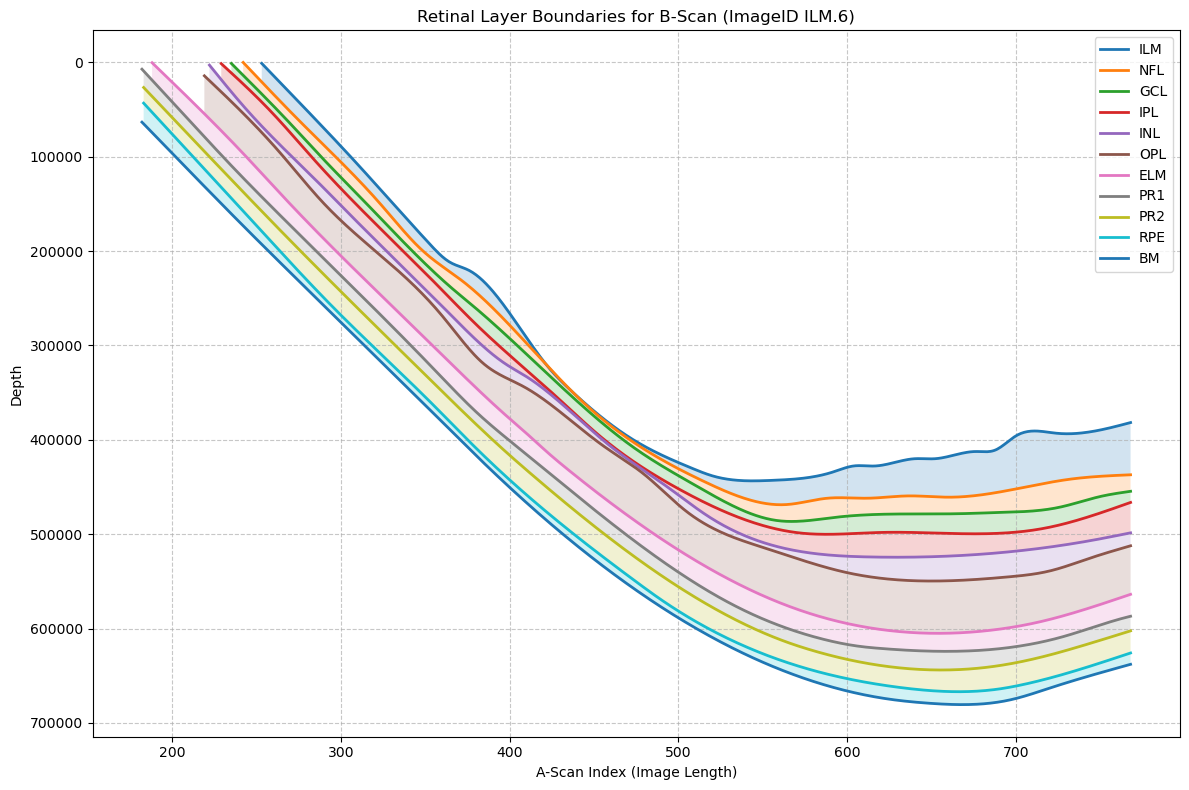

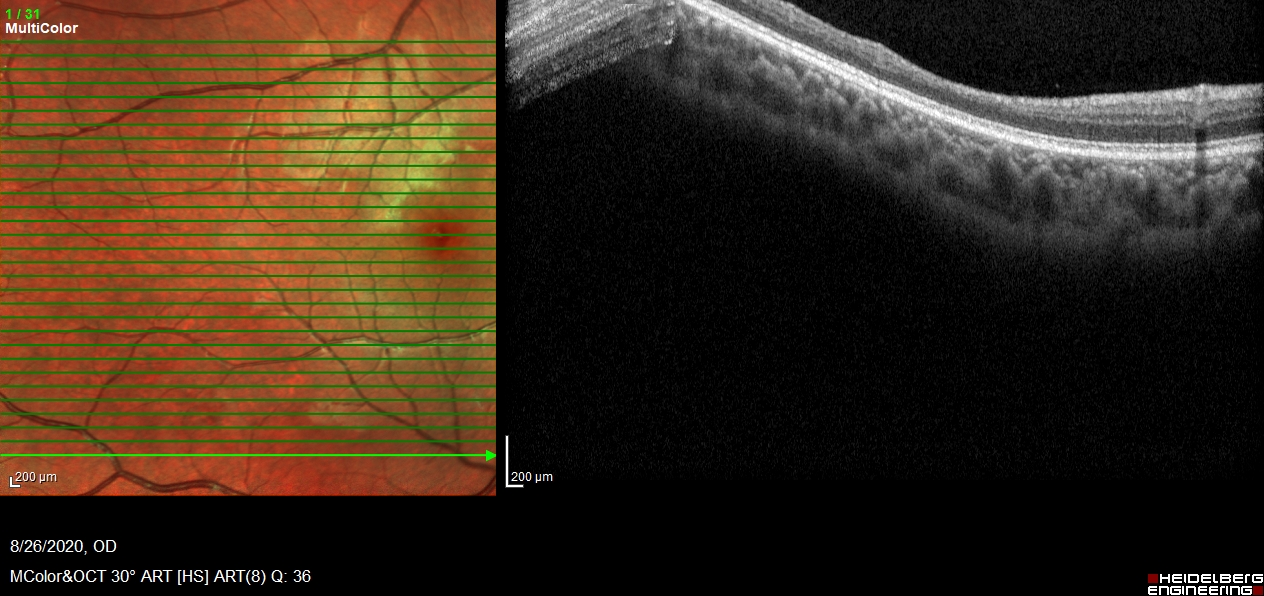

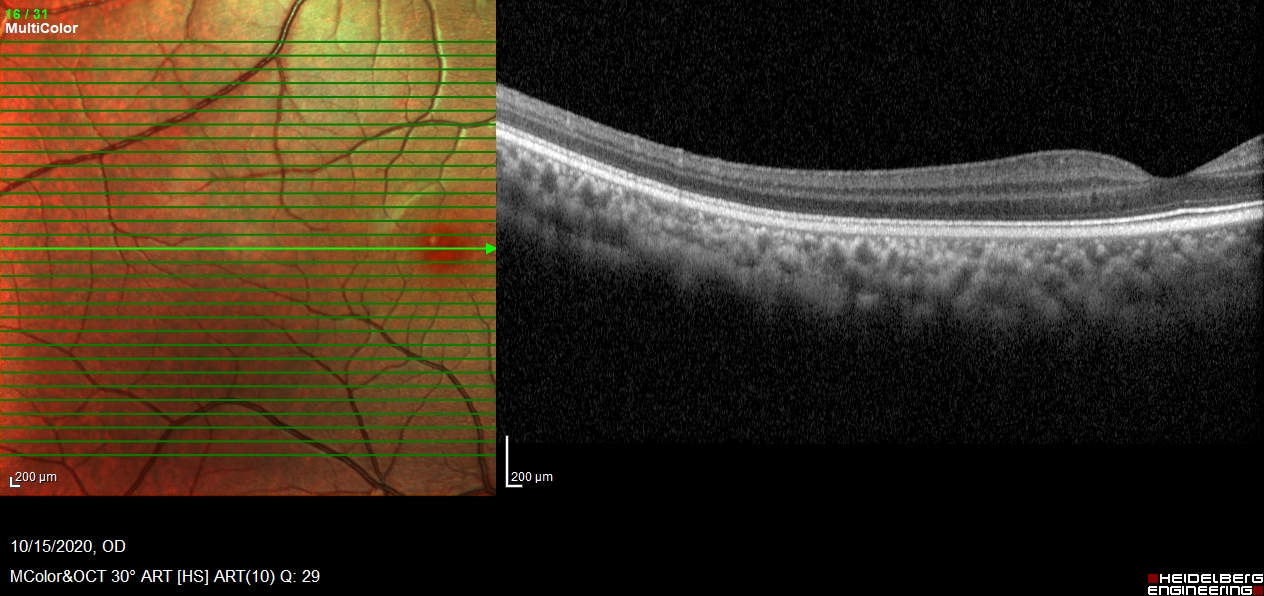
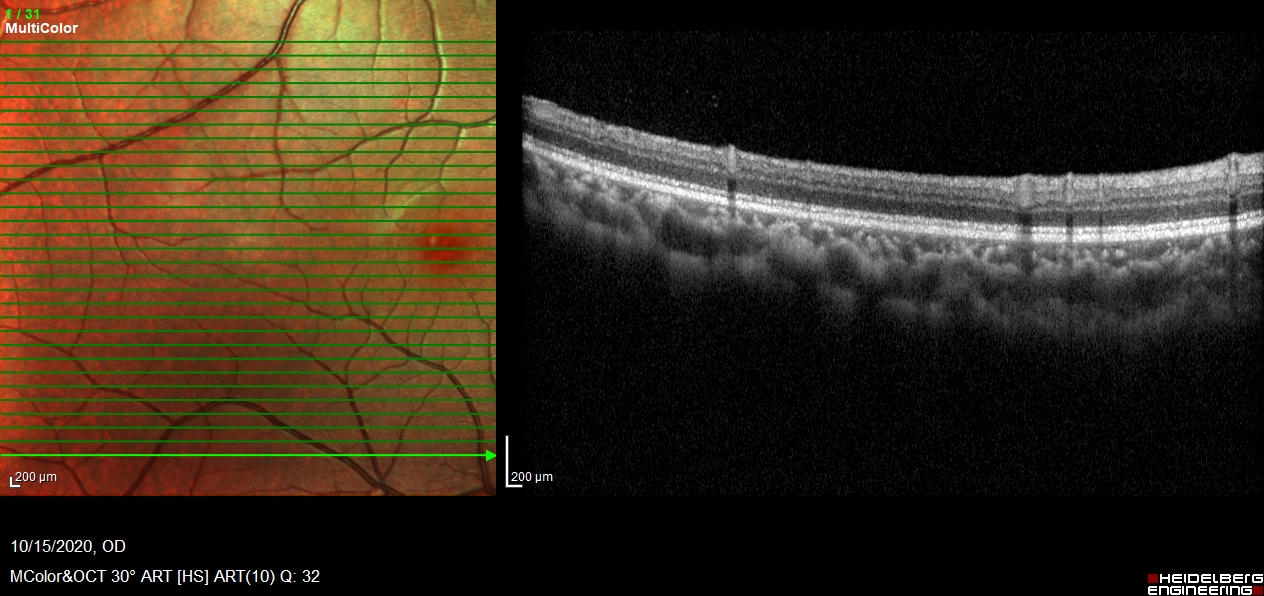

In [1]:
import cv2

img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data/3_R_4_1015.jpg'
# Load image
img = cv2.imread(img_dir)

# annotation region starts at x=0 and ends at x=767 (adjust as needed)
x_end = img.shape[1]           # rightmost pixel
x_start = x_end - 767 
y_start = 0
y_end = img.shape[0]  # full height for now

# Crop image
cropped_img = img[y_start:y_end, x_start:x_end]

# Save or display
cv2.imwrite('cropped_bscan.png', cropped_img)

True

In [22]:
import cv2

img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data/3_R_4_1001.jpg'
# Load image
img = cv2.imread(img_dir)

# annotation region starts at x=0 and ends at x=767 (adjust as needed)
x_end = img.shape[1]           # rightmost pixel
x_start = x_end - 767 
y_start = 0
y_end = img.shape[0]  # full height for now

# Crop image
cropped_img = img[y_start:y_end, x_start:x_end]

# Save or display
cv2.imwrite('cropped_bscan_1001.png', cropped_img)

True

#### Cropped sample image
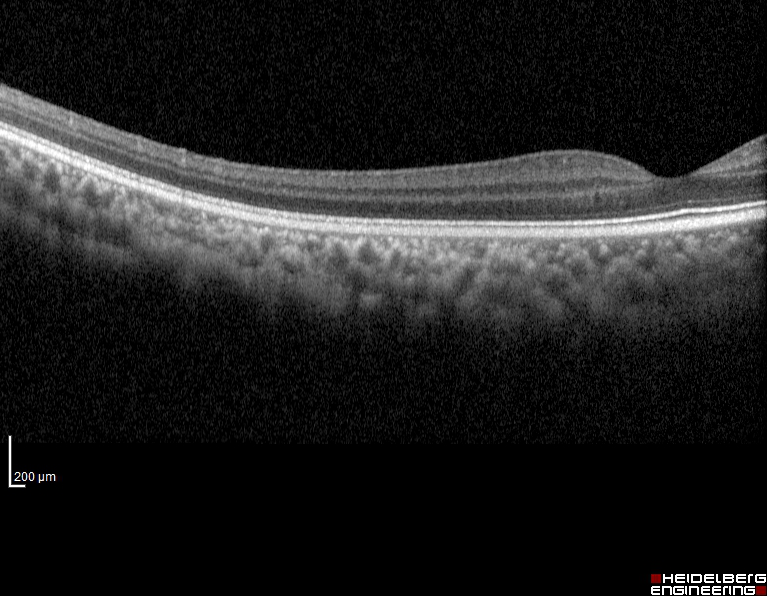

In [2]:
cropped_img = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/cropped_bscan.png'

In [3]:
img = cv2.imread(cropped_img)
height, width = img.shape[:2]
print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")

Image width: 767 pixels
Image height: 596 pixels


In [4]:
image = cv2.imread(cropped_img)

# Threshold for "black" (adjust if needed)
black_thresh = 10

# Find the last non-black row from the bottom
for y in range(image.shape[0]-1, -1, -1):
    if np.mean(image[y, :]) > black_thresh:
        crop_height = y + 1
        break

img_cropped = img[:crop_height, :, :]
cv2.imwrite('cropped_bscan_height.png', img_cropped)
print(f"Cropped image height: {img_cropped.shape[0]}")

NameError: name 'np' is not defined

In [ ]:
img = cv2.imread(cropped_img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Parameters
black_thresh = 20
texture_thresh = 5  # adjust as needed

# Scan from top to bottom, find last row with texture
crop_height = gray.shape[0]
for y in range(gray.shape[0]-1, -1, -1):
    row = gray[y, :]
    if np.mean(row) > black_thresh and np.std(row) > texture_thresh:
        crop_height = y + 1
        break

img_cropped = img[:crop_height, :, :]
cv2.imwrite('cropped_bscan_auto.png', img_cropped)
print(f"Cropped image height: {img_cropped.shape[0]}")

Cropped image height: 594
